# Machine Learning: Project 2
## Task 1

In [47]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

### Loading, Normalizing and 

In [11]:
lfw_people = fetch_lfw_people(
    data_home="/media/abdelrahman/CE92DD4992DD3725/GUC/Semester 9 Winter 2018/CSEN1067. Machine Learning Algorithms/Project/Project 1/code/project2/datasets/task1/lfw_funneled",
    min_faces_per_person=10, resize=0.4,download_if_missing= False)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# print("Total dataset size:",X.shape)
# print("n_samples: %d" % n_samples)
# print("n_features: %d" % n_features)
# print("n_classes: %d" % n_classes)

# Standardize the data set
X = (X - X.mean()) / X.std()

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### C values in SVM model
In the code cell below, for the four C values (1, 10, 100, 1000) in our SVM Classifier:
- 100 got the best results because when C is small it tends to ignore the errors thus resulting in bad validation and test scores, on the other hand, when C grows large it's more likely to adapt to the training data (with a tendancy to not overlook errors which may lead to overfitting) such that it misclassifies the training data. So, the value 100 did best as it was not too large or too small.
- In the tutorial, the best value for C was 1000. It is also possible that this value of C was best because the data hadn't been normalized yet

In [12]:
# Train a SVM classification model
# TODO CHECK FINAL C FOR FINAL DATASET
print("Fitting the classifier to the training set")
param_grid = {'C': [1, 1e1, 1e2, 1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, iid=False)
clf = clf.fit(X_train, y_train)
print("C-value of best estimator found by grid search:", clf.best_estimator_.C)

Fitting the classifier to the training set
C-value of best estimator found by grid search:
100.0


### PCA usage
Using PCA is supposed to accelerate the learning process and it did. We used 3 different values for PCA (50, 150 and 190) and found the best corresponding C-value. The results are plotted below.

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction
used_n_components = []
best_cs = []
performance_acc = []
n_components_arr = [50, 150, 190, 300, 1000]
for n_components in n_components_arr:
    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
    try:
        pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
        used_n_components.append(n_components)
    except ValueError:
        print(n_components, "is too large of a value! Max value allowed is", min(X_train.shape[0], n_features))
        break
        
    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    print("Fitting the classifier to the training set")
    param_grid = {'C': [1, 1e1, 1e2, 1e3], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, iid=False)
    clf = clf.fit(X_train_pca, y_train)
    print("C-value of best estimator found by grid search:", clf.best_estimator_.C)
    best_cs.append(clf.best_estimator_.C)
    y_pred = clf.predict(X_test_pca)
    performance_acc.append(accuracy_score(y_test, y_pred) * 100)
    print("")

Extracting the top 50 eigenfaces from 207 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
C-value of best estimator found by grid search: 1

Extracting the top 150 eigenfaces from 207 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
C-value of best estimator found by grid search: 1000.0

Extracting the top 190 eigenfaces from 207 faces
Projecting the input data on the eigenfaces orthonormal basis
Fitting the classifier to the training set
C-value of best estimator found by grid search: 100.0

Extracting the top 300 eigenfaces from 207 faces
300 is too large of a value! Max value allowed is 207


### Results
TODO: WRITE STUFF!

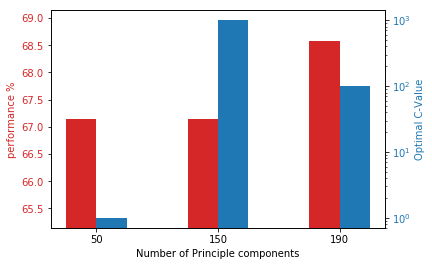

In [68]:
# TODO: TRY OTHER GRAPHS (BAR GRAPH MIGHT BE A GOOD CHOICE)

fig, ax1 = plt.subplots()
plt.xticks(np.arange(len(used_n_components)), used_n_components)

width = 0.25

ax1.set_xlabel('Number of Principle components')

color = 'tab:red'
ax1.set_ylabel('performance %', color=color)
# ax1.plot(used_n_components, performance_acc, color=color)
ax1.bar(np.arange(len(performance_acc)) - width/2, performance_acc, color=color, width=width)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(bottom=np.min(performance_acc) - 2, top=np.min(performance_acc) + 2)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Optimal C-Value', color=color)
# ax2.plot(used_n_components, best_cs, color=color)
ax2.bar(np.arange(len(best_cs)) + width/2, best_cs, color=color, width=width)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")

plt.show()

In [18]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

# print(classification_report.__doc__)

print(classification_report(y_test, y_pred, labels=range(n_classes), target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
                         precision    recall  f1-score   support

         George HW Bush       0.00      0.00      0.00         1
      Gerhard Schroeder       0.73      0.97      0.83        31
Gloria Macapagal Arroyo       0.91      0.91      0.91        11
           Gordon Brown       1.00      1.00      1.00         2
            Igor Ivanov       0.25      0.11      0.15         9
            John Howard       0.00      0.00      0.00         6
     Michael Schumacher       0.25      1.00      0.40         1
       Pervez Musharraf       1.00      0.33      0.50         3
            Tiger Woods       1.00      0.33      0.50         6

              micro avg       0.67      0.67      0.67        70
              macro avg       0.57      0.52      0.48        70
           weighted avg       0.66      0.67      0.63        70

[[ 0  1  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  1  0  0]
 [ 0  0 10  0  0  0  1  0  0]
 [ 0  0  0  2  0  0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [ ]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()